In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import gym
import time

In [81]:
import numpy as np
import math

In [420]:
class ToyTask():
    def __init__(self):
        # World space
        self.world_x_min = 0
        self.world_x_max = 100
        self.world_y_min = 0
        self.world_y_max = 100
        
        # Traps and Goals
        no_traps = True
        if no_traps:
            self.traps = {}
        else:
            self.traps = {'trap1': {'center': (20, 15), 'radius': 5, 'color': 'b'},
                          'trap2': {'center': (35, 60), 'radius': 5, 'color': 'b'},
                          'trap3': {'center': (80, 85), 'radius': 5, 'color': 'b'}}

        self.goals = {'goal1': {'center': (75, 40), 'radius': 5, 'color': 'r'}}
        self.goal_location = np.asarray(self.goals['goal1']['center'], dtype=np.float)
        self.goal_radius = self.goals['goal1']['radius']
        # Observation space: robot position + goal position
        obs_dim = 4
        obs_low = np.array([-np.inf for _ in range(obs_dim)], dtype="float32")
        obs_high = np.array([np.inf for _ in range(obs_dim)], dtype="float32")
        self.observation_space = gym.spaces.Box(obs_low, obs_high)
        
        # Action space: facing direction: radian and step_size: s
        self.act_dim = 2
        self.act_limit_high = 1
        self.act_limit_low = -1
        act_low = np.array([self.act_limit_low for _ in range(self.act_dim)], dtype="float32")
        act_high = np.array([self.act_limit_high for _ in range(self.act_dim)], dtype="float32")
        self.action_space = gym.spaces.Box(act_low, act_high)
        
        self.robot_act_radian_max = 2*np.pi
        self.robot_act_radian_min = 0
        self.robot_act_s_max = 10
        self.robot_act_s_min = 0
        
        # 
        self.axes = None
        self.world_axis = None
    
    def reset(self):
        # Randomly set robot location
        self.robot_old_obs_x = None
        self.robot_old_obs_y = None
        self.dx = None
        self.dy = None
        
        # Clear past trajectory
        if self.world_axis is not None:
            self.world_axis.clear()
            # trap
            for trap in self.traps:
                trap_patch = patches.Circle(self.traps[trap]['center'], radius=self.traps[trap]['radius'], 
                                            color=self.traps[trap]['color'])
                self.world_axis.add_artist(trap_patch)
            # goal
            for goal in self.goals:
                goal_patch = patches.Circle(self.goals[goal]['center'], radius=self.goals[goal]['radius'], 
                                            color=self.goals[goal]['color'])
                self.world_axis.add_artist(goal_patch)
            self.world_axis.set_title('Toy Task')
            self.world_axis.set_aspect('equal', adjustable='box')
            self.world_axis.plot() 
        
        self.robot_obs_x = np.random.rand()*(self.world_x_max-self.world_x_min) + self.world_x_min
        self.robot_obs_y = np.random.rand()*(self.world_y_max-self.world_y_min) + self.world_y_min
        self.robot_location = np.asarray([self.robot_obs_x, self.robot_obs_y], dtype=np.float)
        obs = np.concatenate([self.robot_location, self.goal_location])
        return obs
    
    def step(self, act):
        # Store current robot postition
        self.robot_old_obs_x = self.robot_obs_x
        self.robot_old_obs_y = self.robot_obs_y
        
        # Transform action value to world space value
        act = np.clip(act, self.act_limit_low, self.act_limit_high)
        robot_act_radian = (act[0]-self.act_limit_low)*(self.robot_act_radian_max-self.robot_act_radian_min)/(self.act_limit_high-self.act_limit_low) + self.robot_act_radian_min
        robot_act_s = (act[1]-self.act_limit_low)*(self.robot_act_s_max-self.robot_act_s_min)/(self.act_limit_high-self.act_limit_low) + self.robot_act_s_min
        
        # Transition dynamics: move in the direction with step size robot_act_s
        # Update new robot location
        if robot_act_radian>=0 and robot_act_radian<=(0.5*np.pi):
            self.dx = robot_act_s*math.cos(robot_act_radian)
            self.dy = robot_act_s*math.sin(robot_act_radian)
        elif robot_act_radian>(0.5*np.pi) and robot_act_radian<=np.pi:
            self.dx = -robot_act_s*math.cos(np.pi-robot_act_radian)
            self.dy = robot_act_s*math.sin(np.pi-robot_act_radian)
        elif robot_act_radian>np.pi and robot_act_radian<=(1.5*np.pi):
            self.dx = -robot_act_s*math.cos(robot_act_radian-np.pi)
            self.dy = -robot_act_s*math.sin(robot_act_radian-np.pi)
        else:
            self.dx = robot_act_s*math.cos(2*np.pi-robot_act_radian)
            self.dy = -robot_act_s*math.sin(2*np.pi-robot_act_radian)
            
        self.robot_obs_x = self.robot_obs_x + self.dx
        self.robot_obs_y = self.robot_obs_y + self.dy
            
        # Check if outside the world, then random set a position
        if (self.robot_obs_x > self.world_x_max) or (self.robot_obs_x < self.world_x_min):
            self.robot_obs_x = np.random.rand()*(self.world_x_max-self.world_x_min) + self.world_x_min
        if (self.robot_obs_y > self.world_y_max) or (self.robot_obs_y < self.world_y_min):
            self.robot_obs_y = np.random.rand()*(self.world_y_max-self.world_y_min) + self.world_y_min
        
        # Generate observation
        self.robot_location = np.asarray([self.robot_obs_x, self.robot_obs_y], dtype=np.float)
        obs = np.concatenate([self.robot_location, self.goal_location])
        
        # Calculate reward
        rew, done = self._reward()
        info = {}
        return obs, rew, done, info
        
    def _reward(self):
        # Reward is reverse proportional to the distance of robot from goal.
        distance = np.sqrt(np.sum((self.robot_location - self.goal_location)**2))
        if distance<=self.goal_radius:
            reward = 1
            done = True
        else:
            # Inverse of distance
            reward = 1/distance
            done = False
        return reward, done
    
    def _generate_reward_and_distance_map(self):
        robot_x = np.arange(self.world_x_min, self.world_x_max, 0.1)
        robot_y = np.arange(self.world_y_min, self.world_y_max, 0.1)
        x_len = len(robot_x)
        y_len = len(robot_y)
        reward_map = np.zeros((x_len, y_len))
        distance_map = np.zeros((x_len, y_len))
        for x_i, x in enumerate(robot_x):
            for y_i, y in enumerate(robot_y):
                distance = np.sqrt((x-self.goal_location[0])**2+(y-self.goal_location[1])**2)
                if distance <=  self.goal_radius:
                    reward = 1
                else:
                    # Inverse of distance
                    reward = 1/ distance
                reward_map[y_i, x_i] = reward
                distance_map[y_i, x_i] = distance
        return reward_map, distance_map
    
    def calculate_optimal_V(self, obs, max_ep_len=1000, gamma=0.99):
        """Restore obs, take act, observe reward and new_obs, then follow optimal policy."""
        # Restore obs
        self.robot_obs_x = obs[0]
        self.robot_obs_y = obs[1]
        
        done = False
        accumulated_rew = 0
        accumulated_step = 0
        # Follow optimal policy
        while True:
            if done or (accumulated_step==max_ep_len):
                return accumulated_rew, accumulated_step
            
            optimal_act = self.optimal_policy(obs)
            obs, rew, done, info = self.step(optimal_act)
            
            accumulated_rew += gamma**(accumulated_step)*rew
            accumulated_step += 1
            
    def calculate_optimal_Q(self, obs, act, max_ep_len=1000, gamma=0.99):
        """Restore obs, take act, observe reward and new_obs, then follow optimal policy."""
        # Restore obs
        self.robot_obs_x = obs[0]
        self.robot_obs_y = obs[1]
        
        # Take act, observe reward and new_obs
        obs, rew, done, info = self.step(act)
        accumulated_rew = rew
        accumulated_step = 1
        
        # Follow optimal policy
        while True:
            if done or (accumulated_step==max_ep_len):
                return accumulated_rew, accumulated_step
            
            optimal_act = self.optimal_policy(obs)
            obs, rew, done, info = self.step(optimal_act)
            
            accumulated_rew += gamma**(accumulated_step)*rew
            accumulated_step += 1
        
    def optimal_policy(self, obs):
        # Optimal policy is just move directly to the goal with the maximum of the step size.
        robot_x, robot_y, goal_x, goal_y = obs[0], obs[1], obs[2], obs[3]
        
        # Optimal direction
        epsilon = 1e-15  # Avoid divide by 0
        if goal_y >= robot_y:
            if goal_x >= robot_x:
                robot_act_radian = math.atan(np.abs(goal_y-robot_y)/(np.abs(goal_x-robot_x)+epsilon))
            else:
                robot_act_radian = np.pi - math.atan(np.abs(goal_y-robot_y)/(np.abs(goal_x-robot_x)+epsilon))
        else:
            if goal_x >= robot_x:
                robot_act_radian = 2*np.pi - math.atan(np.abs(goal_y-robot_y)/(np.abs(goal_x-robot_x)+epsilon))
            else:
                robot_act_radian = np.pi + math.atan(np.abs(goal_y-robot_y)/(np.abs(goal_x-robot_x)+epsilon))
        
        # Optimal step size: maximum when outside the goal area, and less than the distance from the edge of the goal area
        distance = np.sqrt((robot_x-self.goal_location[0])**2+(robot_y-self.goal_location[1])**2)
        if distance > self.goal_radius:
            robot_act_s = self.robot_act_s_max
        else:
            robot_act_s = 0
            
        # Tranform action value
        act = np.zeros(self.act_dim)
        act[0] = (robot_act_radian - self.robot_act_radian_min)/(self.robot_act_radian_max-self.robot_act_radian_min)*(self.act_limit_high-self.act_limit_low)+self.act_limit_low
        act[1] = (robot_act_s - self.robot_act_s_min)/(self.robot_act_s_max-self.robot_act_s_min)*(self.act_limit_high-self.act_limit_low)+self.act_limit_low
        return act
    
    def _init_canvas(self, plot_assitant_map = True):
        # Plot
        if plot_assitant_map:
            self.fig, self.axes = plt.subplots(1,3, figsize=(9, 3))

            # trap
            for trap in self.traps:
                trap_patch = patches.Circle(self.traps[trap]['center'], radius=self.traps[trap]['radius'], 
                                            color=self.traps[trap]['color'])
                self.axes[0].add_artist(trap_patch)
            # goal
            for goal in self.goals:
                goal_patch = patches.Circle(self.goals[goal]['center'], radius=self.goals[goal]['radius'], 
                                            color=self.goals[goal]['color'])
                self.axes[0].add_artist(goal_patch)

            self.axes[0].set_xlim(self.world_x_min, self.world_x_max+1)
            self.axes[0].set_ylim(self.world_y_min, self.world_y_max+1)
            #self.axes[0].set_xticks(np.arange(self.world_x_min, self.world_x_max+1, step=10))
            #self.axes[0].set_yticks(np.arange(self.world_y_min, self.world_y_max+1, step=10))
            #self.axes[0].set_xlabel('x')
            #self.axes[0].set_ylabel('y')
            self.axes[0].set_title('Toy Task')
            self.axes[0].set_aspect('equal', adjustable='box')
            self.axes[0].tick_params(axis='both',          # changes apply to the x-axis
                                     which='both',      # both major and minor ticks are affected
                                     bottom=False,      # ticks along the bottom edge are off
                                     top=False,         # ticks along the top edge are off
                                     right=False,
                                     left=False,
                                     labelbottom=False,
                                     labelleft=False) # labels along the bottom edge are off
            self.world_axis = self.axes[0]
            
            # 
            reward_map, distance_map = self._generate_reward_and_distance_map()
            reward_mapable = self.axes[1].imshow(reward_map, cmap='coolwarm', interpolation='nearest', origin='lower', alpha=0.8)
            self.axes[1].set_axis_off()
            self.axes[1].set_title('Reward Map')
            self.fig.colorbar(reward_mapable, extend='both', shrink=0.9, ax=self.axes[1])
            
            distance_mapable = self.axes[2].imshow(distance_map, cmap='coolwarm', interpolation='nearest', origin='lower', alpha=0.8)
            self.axes[2].set_axis_off()
            self.axes[2].set_title('Distance Map')
            self.fig.colorbar(distance_mapable, extend='both', shrink=0.9, ax=self.axes[2])
            
        else:
            self.fig, self.axes = plt.subplots(1,1, figsize=(6,6))

            # trap
            for trap in self.traps:
                trap_patch = patches.Circle(self.traps[trap]['center'], radius=self.traps[trap]['radius'], 
                                            color=self.traps[trap]['color'])
                self.axes.add_artist(trap_patch)
            # goal
            for goal in self.goals:
                goal_patch = patches.Circle(self.goals[goal]['center'], radius=self.goals[goal]['radius'], 
                                            color=self.goals[goal]['color'])
                self.axes.add_artist(goal_patch)

            self.axes.set_xlim(self.world_x_min, self.world_x_max+1)
            self.axes.set_ylim(self.world_y_min, self.world_y_max+1)
            self.axes.set_xticks(np.arange(self.world_x_min, self.world_x_max+1, step=10))
            self.axes.set_yticks(np.arange(self.world_y_min, self.world_y_max+1, step=10))
            self.axes.set_xlabel('x')
            self.axes.set_ylabel('y')
            self.axes.set_title('Toy Task')
            self.world_axis = self.axes
    
    def render(self):
        """Call after step() or reset()"""
        # Init canvas if not exist
        if self.axes is None:
            self._init_canvas()
            
        # Radian
        arrow_params = {'length_includes_head': True, 'shape': 'full', 'head_starts_at_zero': True}
        # Plot robot
        robot_patch = patches.Circle((self.robot_obs_x, self.robot_obs_y), 1, color='k')
        self.world_axis.add_artist(robot_patch)
        
        if self.dx is not None and self.dy is not None:
            self.world_axis.arrow(self.robot_old_obs_x, self.robot_old_obs_y, self.dx, self.dy, 
                                  color='c', head_width=2, **arrow_params)

        #We need to draw *and* flush
        self.fig.canvas.draw()
        self.fig.canvas.flush_events()
        time.sleep(0.001)
        

<IPython.core.display.Javascript object>


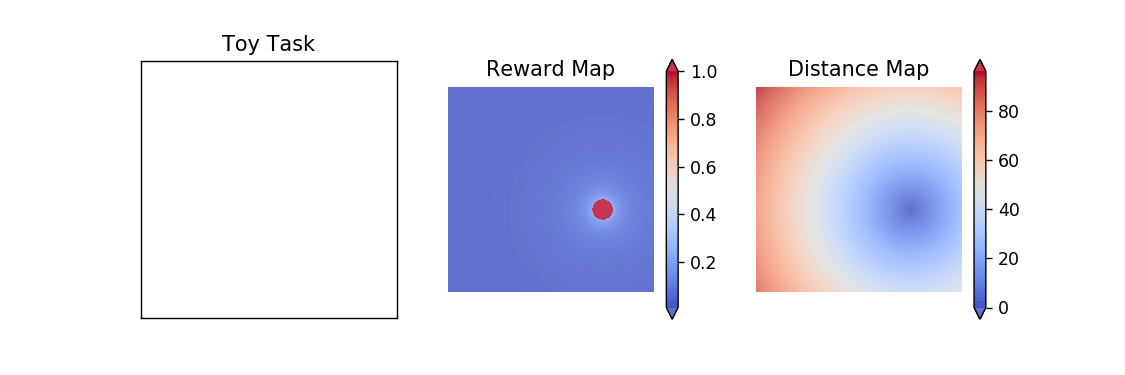

i=0, done=False
i=1, done=False
i=2, done=False
i=3, done=False
i=4, done=False
i=5, done=True


In [421]:
toy_task = ToyTask()
obs = toy_task.reset()
toy_task.render()
max_ep_len = 1000
epochs = 10
done = False
# for ep in np.range(epochs):
    
#     if step >= ma_ep_len
for i in range(100):
    if done:
        break
    # act = toy_task.action_space.sample()
    act = toy_task.optimal_policy(obs)
    obs, rew, done, _ = toy_task.step(act)
    print('i={}, done={}'.format(i,done))
    toy_task.render()

In [422]:
toy_task.reset()

array([60.08636829, 87.89845492, 75.        , 40.        ])

In [401]:
toy_task.world_axis.clear()

In [419]:
toy_task.world_axis.plot()

[]

In [392]:
self = toy_task
# trap
for trap in self.traps:
    trap_patch = patches.Circle(self.traps[trap]['center'], radius=self.traps[trap]['radius'], 
                                color=self.traps[trap]['color'])
    self.world_axis.add_artist(trap_patch)
# goal
for goal in self.goals:
    goal_patch = patches.Circle(self.goals[goal]['center'], radius=self.goals[goal]['radius'], 
                                color=self.goals[goal]['color'])
    self.world_axis.add_artist(goal_patch)

In [372]:
obs = toy_task.reset()
toy_task.render()

In [370]:
obs = toy_task.reset()

done = False
for i in range(100):
    if done:
        break
    obs, rew, done, _ = toy_task.step(toy_task.action_space.sample())
#     obs, rew, done, _ = toy_task.step(toy_task.optimal_policy(obs))
    toy_task.render()

In [153]:
toy_task = ToyTask()
obs = toy_task.reset()

obs = toy_task.observation_space.sample()
act = toy_task.action_space.sample()
accumated_rew, accumated_step = toy_task.calculate_optimal_Q(obs, act, max_ep_len=1000, gamma=0.99)
print('accumated_step = {}, accumated_rew = {}'.format(accumated_step, accumated_rew))

accumated_step = 9, accumated_rew = 7.6602789800583215


C:\ProgramData\Anaconda3\envs\app_cloud\lib\site-packages\ipykernel_launcher.py:179: RuntimeWarning: invalid value encountered in double_scalars


(nan, 1000)

In [355]:
toy_task = ToyTask()
obs = toy_task.reset()

obs = toy_task.observation_space.sample()
accumated_rew, accumated_step = toy_task.calculate_optimal_V(obs, max_ep_len=1000, gamma=0.99)
print('accumated_step = {}, accumated_rew = {}'.format(accumated_step, accumated_rew))

self = toy_task 
sample_strike = 0.5
robot_x = np.arange(self.world_x_min, self.world_x_max, sample_strike)
robot_y = np.arange(self.world_y_min, self.world_y_max, sample_strike)
x_len = len(robot_x)
y_len = len(robot_y)
value_function_map = np.zeros((x_len, y_len))
accumulated_step_map = np.zeros((x_len, y_len))

for x_i, x in enumerate(robot_x):
    if x_i % 100 == 0:
        print('x_i={}'.format(x_i))
    for y_i, y in enumerate(robot_y):
        if y_i % 100 == 0:
            print('\t y_i={}'.format(y_i))
        robot_location = np.asarray([x, y], dtype=np.float)
        obs = np.concatenate([robot_location, self.goal_location])
        accumulated_rew, accumulated_step = toy_task.calculate_optimal_V(obs, max_ep_len=1000, gamma=0.99)
        if accumulated_step == 1000:
            import pdb; pdb.set_trace()
        value_function_map[y_i, x_i] = accumulated_rew
        accumulated_step_map[y_i, x_i] = accumulated_step

accumated_step = 9, accumated_rew = 1.189123173499469
x_i=0
	 y_i=0
	 y_i=100
	 y_i=0
	 y_i=100
	 y_i=0
	 y_i=100
	 y_i=0
	 y_i=100
	 y_i=0
	 y_i=100
	 y_i=0
	 y_i=100
	 y_i=0
	 y_i=100
	 y_i=0
	 y_i=100
	 y_i=0
	 y_i=100
	 y_i=0
	 y_i=100
	 y_i=0
	 y_i=100
	 y_i=0
	 y_i=100
	 y_i=0
	 y_i=100
	 y_i=0
	 y_i=100
	 y_i=0
	 y_i=100
	 y_i=0
	 y_i=100
	 y_i=0
	 y_i=100
	 y_i=0
	 y_i=100
	 y_i=0
	 y_i=100
	 y_i=0
	 y_i=100
	 y_i=0
	 y_i=100
	 y_i=0
	 y_i=100
	 y_i=0
	 y_i=100
	 y_i=0
	 y_i=100
	 y_i=0
	 y_i=100
	 y_i=0
	 y_i=100
	 y_i=0
	 y_i=100
	 y_i=0
	 y_i=100
	 y_i=0
	 y_i=100
	 y_i=0
	 y_i=100
	 y_i=0
	 y_i=100
	 y_i=0
	 y_i=100
	 y_i=0
	 y_i=100
	 y_i=0
	 y_i=100
	 y_i=0
	 y_i=100
	 y_i=0
	 y_i=100
	 y_i=0
	 y_i=100
	 y_i=0
	 y_i=100
	 y_i=0
	 y_i=100
	 y_i=0
	 y_i=100
	 y_i=0
	 y_i=100
	 y_i=0
	 y_i=100
	 y_i=0
	 y_i=100
	 y_i=0
	 y_i=100
	 y_i=0
	 y_i=100
	 y_i=0
	 y_i=100
	 y_i=0
	 y_i=100
	 y_i=0
	 y_i=100
	 y_i=0
	 y_i=100
	 y_i=0
	 y_i=100
	 y_i=0
	 y_i=100
	 y_i=0
	 y_i=100
	 y_

In [264]:
# (value_function_map- value_function_map.min())/(value_function_map.max() - value_function_map.min())*2-1

In [357]:
accumulated_step_map.max()

10.0

<IPython.core.display.Javascript object>


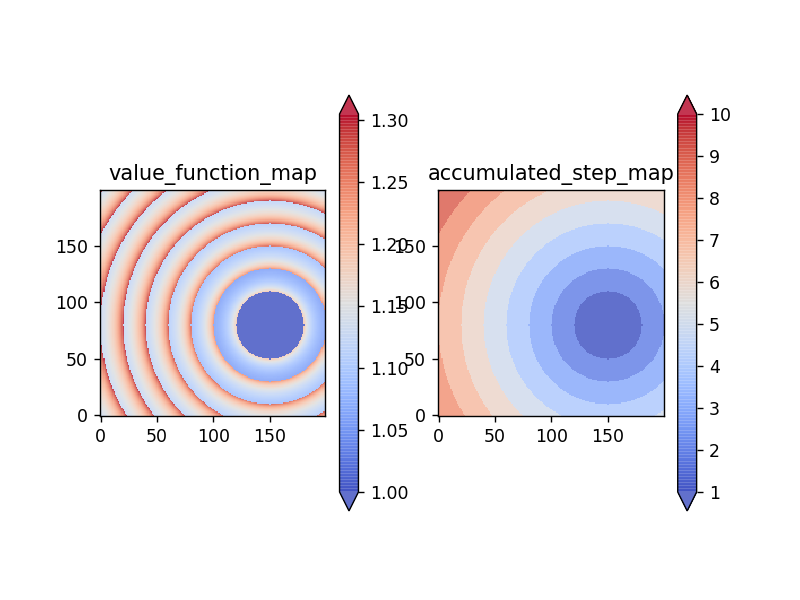

In [356]:
fig, axes = plt.subplots(1,2)
value_function_mapable = axes[0].imshow(value_function_map, 
               cmap='coolwarm', interpolation='nearest', origin='lower', alpha=0.8)
# axes[0].set_axis_off()
axes[0].set_title('value_function_map')
fig.colorbar(value_function_mapable, extend='both', shrink=0.9, ax=axes[0])

accumulated_step_mapable = axes[1].imshow(accumulated_step_map, cmap='coolwarm', interpolation='nearest', origin='lower', alpha=0.8)
# axes[1].set_axis_off()
axes[1].set_title('accumulated_step_map')
fig.colorbar(accumulated_step_mapable, extend='both', shrink=0.9, ax=axes[1])

In [287]:
x = 1
robot_act_radian = (x-self.act_limit_low)*(self.robot_act_radian_max-self.robot_act_radian_min)/(self.act_limit_high-self.act_limit_low) + self.robot_act_radian_min

In [289]:
math.cos(1/4*np.pi)

0.7071067811865476

In [291]:
math.degrees(1/4*np.pi)

45.0

<IPython.core.display.Javascript object>


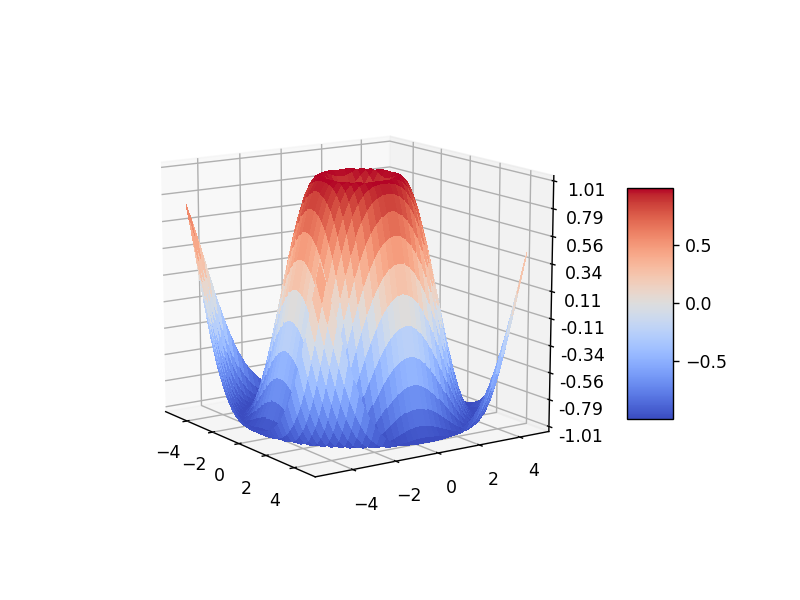

In [156]:
'''
======================
3D surface (color map)
======================

Demonstrates plotting a 3D surface colored with the coolwarm color map.
The surface is made opaque by using antialiased=False.

Also demonstrates using the LinearLocator and custom formatting for the
z axis tick labels.
'''

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np


fig = plt.figure()
ax = fig.gca(projection='3d')

# Make data.
X = np.arange(-5, 5, 0.25)
Y = np.arange(-5, 5, 0.25)
X, Y = np.meshgrid(X, Y)
R = np.sqrt(X**2 + Y**2)
Z = np.sin(R)

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_zlim(-1.01, 1.01)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()
